<a href="https://colab.research.google.com/github/Praise22etta/CM3038-Labs/blob/main/CV_2116036.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1 : Research**

Title of paper - **Multiple instance learning for histopathological breast cancer image classification**
 https://www.sciencedirect.com/science/article/pii/S0957417418306262


Link to dataset - https://www.kaggle.com/datasets/ambarish/breakhis

This paper offers a comprehensive investigation into the application of Multiple Instance Learning (MIL) for classifying histopathological breast cancer images using the publicly available BreaKHis dataset. It addresses the challenge of expensive image-level annotation in medical imaging by exploring a weakly supervised learning paradigm, where diagnostic labels are provided at the patient level (bags) but not at the image (instance) level. The primary objective is to compare the performance of various MIL techniques, including traditional algorithms and a deep learning-based method (MILCNN), for both patient-level and image-level classification, and to benchmark them against single-instance learning approaches.

Technically, the authors model patients as bags of histopathological images, or individual images as bags of small patches. The study compares several well-established MIL algorithms—Axis-Parallel Rectangle (APR), Diverse Density (DD), EM-DD, Citation-kNN, mi-SVM, and MI-SVM (with various kernel functions)—alongside a newer non-parametric MIL method and MILCNN. For traditional (non-deep learning) approaches, images were divided into 64×64 patches and described using Parameter-Free Threshold Adjacency Statistics (PFTAS) features. Experiments were conducted on a 70%/30% patient-level train/test split, and classification accuracy was averaged over five trials. Hyperparameters for each method were optimized via manual grid search. The MIL methods were also compared to several single-instance classifiers—1-NN, QDA, RF, SVM with PFTAS features, and a CNN (AlexNet) using a Max Fusion Rule—trained under the assumption that instances inherit the bag label.

The results support the utility of the MIL framework in histopathological image classification. Among the reviewed methods, nearest neighbor-based models and MILCNN achieved the highest performance across various magnification levels for both patient- and image-level tasks. The non-parametric MIL method, using PFTAS features, achieved a patient-level classification accuracy of up to 92.1% at 40× magnification. These MIL methods generally outperformed their single-instance counterparts, which rely on stronger labeling assumptions. While CNN-based single-instance classifiers yielded comparable or slightly better results in some cases, they required image-level annotations, reinforcing the value of the MIL approach for weakly labeled datasets.

One key limitation of the study relates to the fact that accuracy is the only threshold of performance considered. While informative, accuracy can be deceptive, particularly when data is imbalanced. More robust metrics, such as precision, recall, or F1-score,would provide a more comprehensive evaluation of classifier performance. While the authors do not acknowledge this as a limitation, it remains an important consideration.

This paper is of high quality for several reasons. It is peer-reviewed and published in *Expert Systems With Applications*, a respected journal in applied artificial intelligence, indicating that it has been vetted by experts in the field. The methods and results are clearly described and reproducible. Furthermore, the study tackles a significant problem in medical imaging: the lack of detailed annotations. By demonstrating that high classification performance is achievable with weak labels using MIL, the paper contributes meaningfully to the development of practical, scalable solutions for computer-aided diagnosis in histopathology.



# **Part 1.2 : Data Exploration**

In [ ]:
# import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define the root directory for the processed dataset
main_split_dir = "/content/gdrive/MyDrive/BreaKHis_v1/processed_split"

In [ ]:
!find /content/gdrive/MyDrive/ -type d -name "benign"
!find /content/gdrive/MyDrive/ -type d -name "malignant"


/content/gdrive/MyDrive/BreaKHis_v1/benign
/content/gdrive/MyDrive/BreaKHis_v1/processed_split/Training/benign
/content/gdrive/MyDrive/BreaKHis_v1/processed_split/Validation/benign
/content/gdrive/MyDrive/BreaKHis_v1/processed_split/Testing/benign
/content/gdrive/MyDrive/BreaKHis_v1/malignant
/content/gdrive/MyDrive/BreaKHis_v1/processed_split/Training/malignant
/content/gdrive/MyDrive/BreaKHis_v1/processed_split/Validation/malignant
/content/gdrive/MyDrive/BreaKHis_v1/processed_split/Testing/malignant


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd

# STEP 1: Set main directory
main_dir = "/content/gdrive/MyDrive/BreaKHis_v1"
labels = ["benign", "malignant"]
magnifications = ["40X", "100X", "200X", "400X"]

# STEP 2: Recursively find all image paths
data = []

for label in labels:
    for root, dirs, files in os.walk(os.path.join(main_dir, label)):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                if any(mag in root for mag in magnifications):
                    # Detect magnification from folder name
                    mag = [m for m in magnifications if m in root][0]
                    full_path = os.path.join(root, file)
                    data.append([full_path, label, mag])

df = pd.DataFrame(data, columns=["image_path", "class", "magnification"])
print(f"✅ Total images found: {len(df)}")
df.head()


✅ Total images found: 7909


,image_path,class,magnification
0,/content/gdrive/MyDrive/BreaKHis_v1/benign/SOB...,benign,100X
1,/content/gdrive/MyDrive/BreaKHis_v1/benign/SOB...,benign,100X
2,/content/gdrive/MyDrive/BreaKHis_v1/benign/SOB...,benign,100X
3,/content/gdrive/MyDrive/BreaKHis_v1/benign/SOB...,benign,100X
4,/content/gdrive/MyDrive/BreaKHis_v1/benign/SOB...,benign,100X


In [ ]:
# STEP 3: Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# STEP 4: Define destination folders
base_out = os.path.join(main_dir, "processed_split")
train_out = os.path.join(base_out, "Training")
val_out = os.path.join(base_out, "Validation")
test_out = os.path.join(base_out, "Testing")

for folder in [train_out, val_out, test_out]:
    os.makedirs(folder, exist_ok=True)

# Helper function to move files
def move_images(subset_df, target_folder):
    for _, row in subset_df.iterrows():
        label = row["class"]
        mag = row["magnification"]
        src = row["image_path"]
        filename = os.path.basename(src)
        dst_dir = os.path.join(target_folder, label, mag)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src, os.path.join(dst_dir, filename))

# STEP 5: Move the images
move_images(train_df, train_out)
move_images(val_df, val_out)
move_images(test_df, test_out)

print("All files split and copied successfully!")


All files split and copied successfully!


In [ ]:
train_folder_path = os.path.join(main_split_dir, "Training")
val_folder_path = os.path.join(main_split_dir, "Validation")
test_folder_path = os.path.join(main_split_dir, "Testing")
labels = ["benign", "malignant"]
img_size = 128


In [ ]:
main_split_dir = "/content/gdrive/MyDrive/BreaKHis_v1/processed_split"
train_folder_path = os.path.join(main_split_dir, "Training")
val_folder_path = os.path.join(main_split_dir, "Validation")
test_folder_path = os.path.join(main_split_dir, "Testing")

labels = ["benign", "malignant"]
img_size = 128


In [ ]:
def count_images_in_directory(path):
    total = 0
    for label in labels:
        class_path = os.path.join(path, label)
        for mag in os.listdir(class_path):
            mag_path = os.path.join(class_path, mag)
            total += len(os.listdir(mag_path))
    return total

train_count = count_images_in_directory(train_folder_path)
val_count = count_images_in_directory(val_folder_path)
test_count = count_images_in_directory(test_folder_path)

print(f"Training set: {train_count} images")
print(f"Validation set: {val_count} images")
print(f"Testing set: {test_count} images")
print(f"Image input size: {img_size}x{img_size}")


Training set: 6327 images
Validation set: 791 images
Testing set: 791 images
Image input size: 128x128


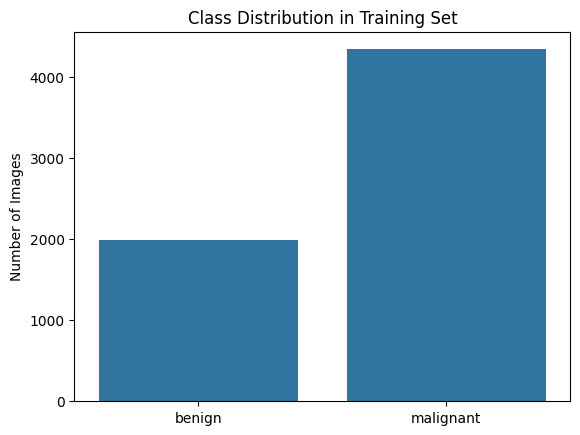

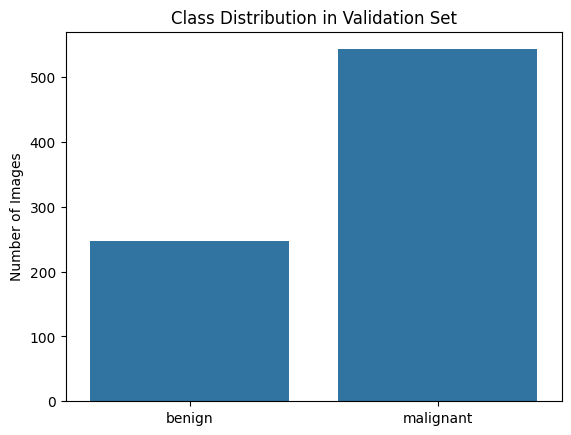

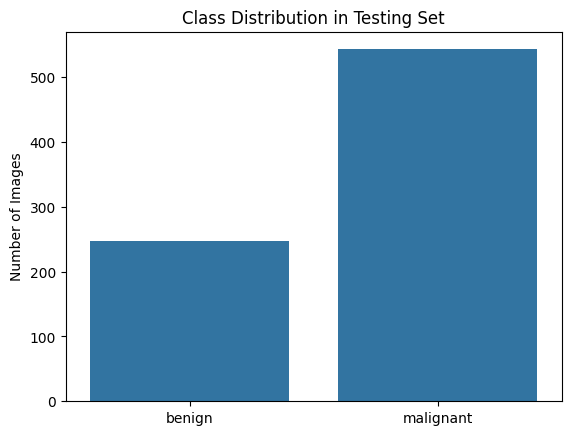

In [ ]:
def class_distribution_plot(path, title):
    counts = {"benign": 0, "malignant": 0}
    for label in labels:
        class_path = os.path.join(path, label)
        for mag in os.listdir(class_path):
            mag_path = os.path.join(class_path, mag)
            counts[label] += len(os.listdir(mag_path))

    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.show()

class_distribution_plot(train_folder_path, "Class Distribution in Training Set")
class_distribution_plot(val_folder_path, "Class Distribution in Validation Set")
class_distribution_plot(test_folder_path, "Class Distribution in Testing Set")


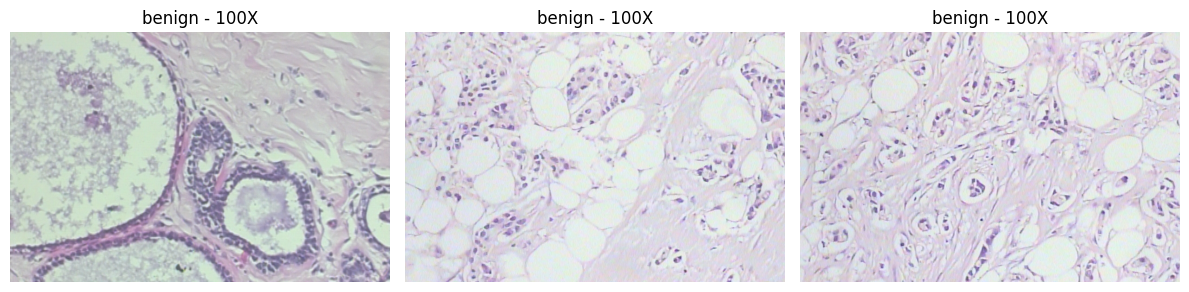

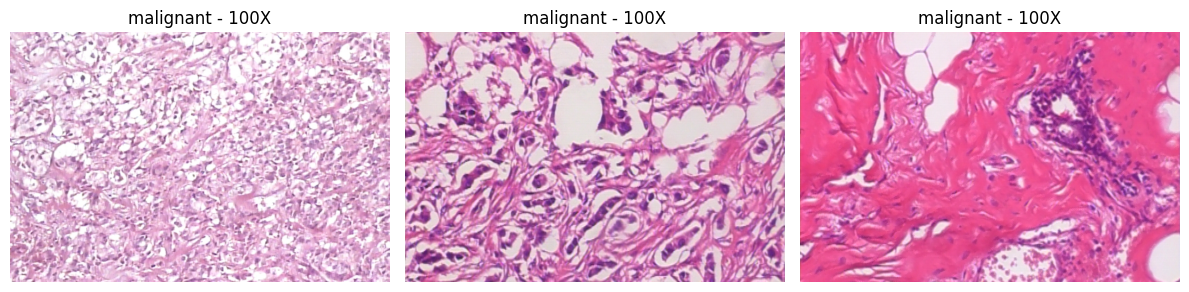

In [ ]:
from PIL import Image

def show_sample_images(folder, label, mag="100X", num=3):
    path = os.path.join(folder, label, mag)
    image_files = os.listdir(path)[:num]  # Only take the first few files

    plt.figure(figsize=(12, 4))
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(path, img_name)
        try:
            img = Image.open(img_path)
            plt.subplot(1, num, i+1)
            plt.imshow(img)
            plt.title(f"{label} - {mag}")
            plt.axis("off")
        except Exception as e:
            print(f"❌ Error loading image {img_name}: {e}")
    plt.tight_layout()
    plt.show()

# Try with 3 images only to avoid overload
show_sample_images(train_folder_path, "benign", "100X", num=3)
show_sample_images(train_folder_path, "malignant", "100X", num=3)


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels_list = []
    for label in labels:
        class_path = os.path.join(folder, label)
        for mag in os.listdir(class_path):
            mag_path = os.path.join(class_path, mag)
            for img_name in os.listdir(mag_path):
                img_path = os.path.join(mag_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_size, img_size))
                    images.append(img / 255.0)  # Normalize
                    labels_list.append(0 if label == "benign" else 1)
                except:
                    pass
    return np.array(images), np.array(labels_list)

x_train, y_train = load_images_from_folder(train_folder_path)
x_val, y_val = load_images_from_folder(val_folder_path)
x_test, y_test = load_images_from_folder(test_folder_path)

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")


x_train shape: (6327, 128, 128, 3)
x_val shape: (791, 128, 128, 3)
x_test shape: (791, 128, 128, 3)


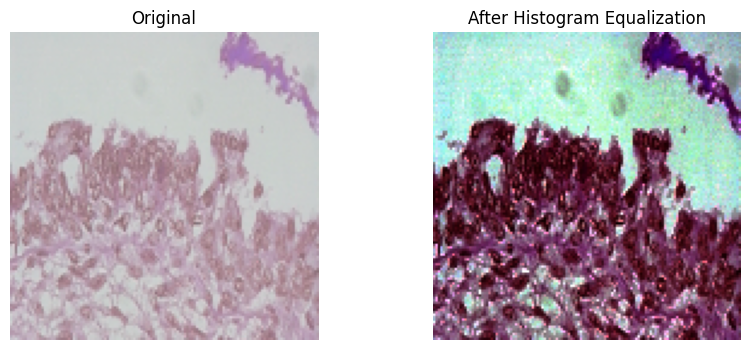

In [ ]:
from skimage import exposure

def show_histogram_equalization(img):
    enhanced = exposure.equalize_hist(img)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced)
    plt.title("After Histogram Equalization")
    plt.axis("off")
    plt.show()

# Show on one random image
show_histogram_equalization(x_train[0])


In [ ]:
dims = [img.shape for img in x_train]
print(f"Unique image dimensions in training set: {set(dims)}")


Unique image dimensions in training set: {(128, 128, 3)}


# **Part 2- Baseline Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_baseline_cnn(input_shape):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully connected
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=1e-6)


In [ ]:
input_shape = (img_size, img_size, 3)
baseline_model = build_baseline_cnn(input_shape)

history = baseline_model.fit(
    x_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.7562 - loss: 1.5444 - val_accuracy: 0.6865 - val_loss: 18.5306 - learning_rate: 0.0010
Epoch 2/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.7996 - loss: 0.3970 - val_accuracy: 0.6915 - val_loss: 20.2250 - learning_rate: 0.0010
Epoch 3/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.8029 - loss: 0.3971 - val_accuracy: 0.8369 - val_loss: 2.2669 - learning_rate: 0.0010
Epoch 4/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.7981 - loss: 0.3755 - val_accuracy: 0.7724 - val_loss: 3.0132 - learning_rate: 0.0010
Epoch 5/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8069 - loss: 0.3709
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
198/198 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.8069 - loss: 0.3709 - val_accuracy: 0.8293 - val_loss: 0.4661 - learning_rate: 0.0010
Epoch 6/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.8568 - loss: 0.3

<Axes: title={'center': 'Model Loss'}>

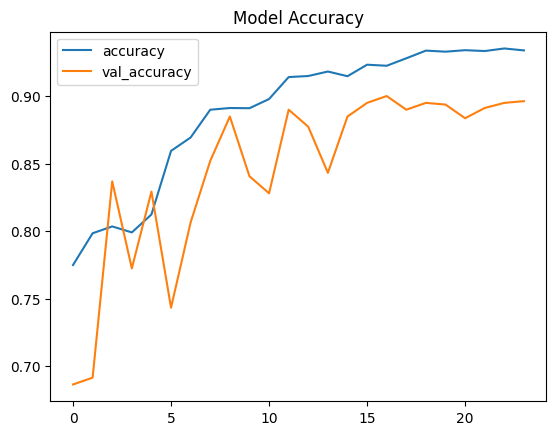

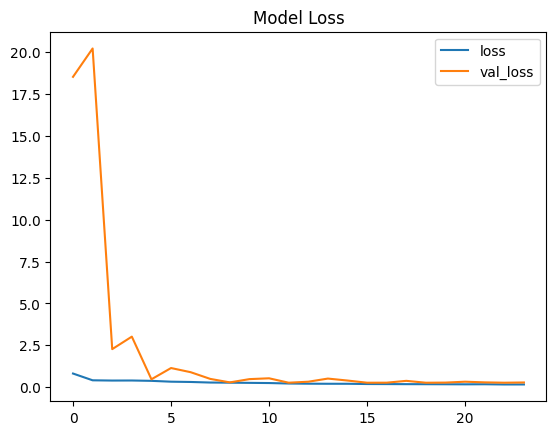

In [ ]:
import pandas as pd

losses = pd.DataFrame(history.history)
losses[['accuracy', 'val_accuracy']].plot(title="Model Accuracy")
losses[['loss', 'val_loss']].plot(title="Model Loss")


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step


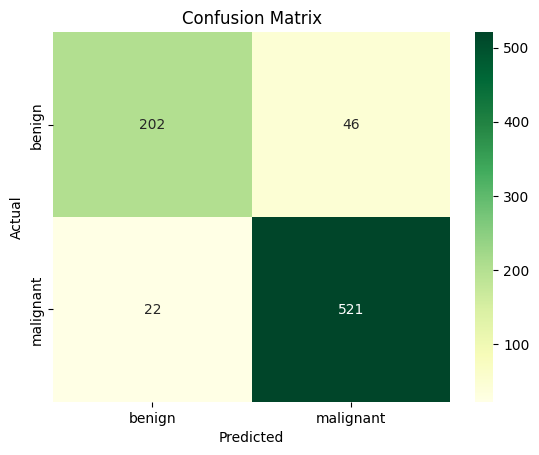

              precision    recall  f1-score   support

      benign       0.90      0.81      0.86       248
   malignant       0.92      0.96      0.94       543

    accuracy                           0.91       791
   macro avg       0.91      0.89      0.90       791
weighted avg       0.91      0.91      0.91       791



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = (baseline_model.predict(x_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGn", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=labels))


# **Part 3 - Solution improvement**

# **Part 4 - Conclusion and Future Direction**